In [1]:
import os
import pathlib
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Path variables
This section defines simply the absolute path to the direcoties where the ground truth (GT) data should be stored.

Relative to the root fodler of the repo, it would be data/ground_truth/... but the `DATA_DIR` definition makes it agnostic to where you have your repo.

**pathlib** is one of the correct ways to manage paths of location in your pc, NOT using strings straight away.

In [2]:
ROOT_DIR = pathlib.Path(os.getcwd()).parent
DATA_DIR = ROOT_DIR / "data/ground_truth"
SEQ_01 = DATA_DIR / "seq_01"
SEQ_02 = DATA_DIR / "seq_01"
SEQ_03 = DATA_DIR / "seq_01"

# Accessing base information
## Accessing frames

In [4]:
def get_frames(frame_num_, seq_dir_):
    """
    returns the right and left frames of the given sequence for a given frame number
    :param frame_num_: frame number (int)
    :param seq_dir_: sequence directory (pathlib.Path)
    :return: right and left frame (np.ndarray, np.ndarray)
    """
    _frame_name_r = str(seq_dir_ / "image_02/data" / f"{frame_num_:010d}.png")
    _frame_name_l = str(seq_dir_ / "image_03/data" / f"{frame_num_:010d}.png")

    if not os.path.isfile(_frame_name_r):
        raise FileNotFoundError(f"File {_frame_name_r} not found")
    if not os.path.isfile(_frame_name_l):
        raise FileNotFoundError(f"File {_frame_name_l} not found")
    
    return cv.cvtColor(cv.imread(_frame_name_r), cv.COLOR_BGR2RGB), cv.cvtColor(cv.imread(_frame_name_l), cv.COLOR_BGR2RGB)

## Accessing ground truth


In [49]:
def get_labels_df(seq_dir_):
    """
    returns the labels (ground truth data) of the given sequence as a pandas dataframe
    :param seq_dir_: sequence directory (pathlib.Path)
    :return: labels dataframe (pd.DataFrame)
    """

    _labels_file = str(seq_dir_ / "labels.txt")
    headers = ['frame', 'track_id', 'type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'x', 'y', 'z', 'yaw']
    return pd.read_csv(_labels_file, sep=' ', header=None, names=headers)

In [50]:
# get labels df
labels_df = get_labels_df(SEQ_01)

# make dfs for each type
car_df = labels_df[labels_df['type'] == 'Car']
pedestrian_df = labels_df[labels_df['type'] == 'Pedestrian']
cyclist_df = labels_df[labels_df['type'] == 'Cyclist']

print(f"pedestrian ids: {pedestrian_df['track_id'].unique()}")
print(f"car ids: {car_df['track_id'].unique()}")
print(f"cyclist ids: {cyclist_df['track_id'].unique()}")

pedestrian ids: [0 1 5 6 7 8 2 3 4]
car ids: []
cyclist ids: [ 9 10]


## Showing tracking in image

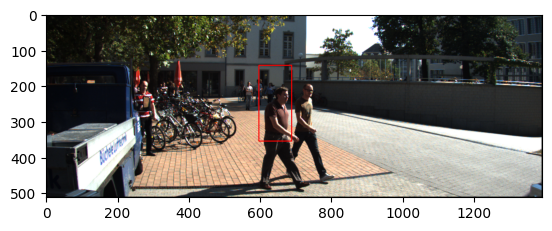

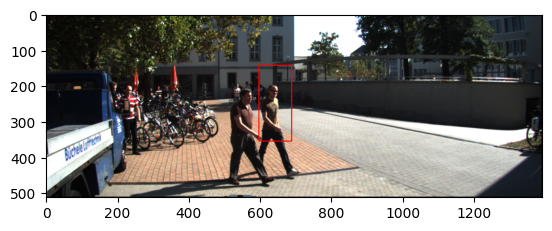

In [61]:
# draw boxes on frame
def draw_bboxes(frame_, bbox_coords_):
    _frame = frame_.copy()
    for bbox in bbox_coords_:
        cv.rectangle(_frame, (int(_bb[0]), int(_bb[1])), (int(_bb[2]), int(_bb[3])), (255, 0, 0), 2)
    return _frame

# select sequence
seq = SEQ_01

labels_df = get_labels_df(seq)

# get a specific tracked object's info
track_id = 0
test_df = pedestrian_df[pedestrian_df['track_id'] == track_id]

frames = test_df['frame'].values
world_coords = test_df[['x', 'y', 'z']].values
bbox_coords = test_df[['bbox_left', 'bbox_top', 'bbox_right', 'bbox_bottom']].values

# showing bboxes for object on a given frame 
_fr_num = 10
fr, fl = get_frames(_fr_num, seq)
_bb = bbox_coords[_fr_num]

plt.imshow(draw_bboxes(fr, _bb))
plt.show()
plt.imshow(draw_bboxes(fl, _bb))

## Plotting 3D Coordinates

In [68]:
# plot the world coordinates in 3D, with frame next to the point as text with plotly
# fig = px.scatter_3d(x=world_coords[:, 0], y=world_coords[:, 1], z=world_coords[:, 2], text=frames)
fig = px.scatter(x=world_coords[:, 0], y=world_coords[:, 1], text=frames)
# show origin 0,0 on plot
plot_w = 5
plot_h = 5
fig.update_xaxes(range=[-2, plot_w])
fig.update_yaxes(range=[-0, plot_h])
fig.show()